In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
img_dir = './dataset/Flickr8k_Dataset/'
ann_dir = './dataset/Flickr8k_text/Flickr8k.token.txt'

In [3]:
class Flickr8kDataset(Dataset):
    """Flickr8k dataset."""
    
    def __init__(self, img_dir, ann_dir, transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.
            ann_dir (string): Directory with all the tokens
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.image_2_caption, self.V, self.SOS, self.EOS = self.tokenizer(self.ann_dir)
        self.transform = transform
        
    
    def tokenizer(self, ann_dir):
        image_2_caption = {}
        with open(ann_dir, "r") as ann_f:
            lines = ann_f.readlines()

        for line in lines:
            image_2_caption[line.split()[0]] = line.split()[1:]

        caption_list = list(image_2_caption.values())

        vocab = []
        for caption in caption_list:
            for word in caption:
                if word not in vocab:
                    vocab.append(word)

        V = len(vocab)
        SOS = 0
        EOS = V + 1

        word_2_token = dict(zip(vocab, list(range(1, V + 1))))

        for item in image_2_caption:
            for i in range(len(image_2_caption[item])):
                image_2_caption[item][i] = word_2_token[image_2_caption[item][i]]
            image_2_caption[item].insert(0, SOS)
            image_2_caption[item].append(EOS)
            
        return image_2_caption, V, SOS, EOS
        

    def __len__(self):
        return len(self.image_2_caption)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name, cap_tok = tuple(self.image_2_caption.items())[idx]
        img_name, instance = img_name.split('#')
        img_name = os.path.join(self.img_dir,
                                img_name)
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        landmarks = np.array(cap_tok)
        sample = {'image': image, 'instance': instance, 'cap_tok': cap_tok}

        

        return sample

In [4]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
dataset = Flickr8kDataset(img_dir, ann_dir, preprocess)

In [6]:
def display_sample(sample):
    image = sample['image']
    caption = sample['cap_tok']
    plt.figure()
    plt.imshow(image.permute(1,2,0))
    print("Tokenized caption: ", caption)
    plt.show()

Tokenized caption:  [0, 1, 257, 30, 13, 258, 137, 259, 260, 81, 24, 261, 137, 63, 87, 25, 4, 262, 36, 4, 132, 81, 263, 16, 9631]


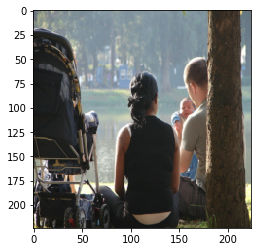

In [7]:
display_sample(dataset[85])

In [8]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [9]:
# for data in dataloader:
#     print(data)

things to do
1) Make the sequences equal length by padding
2) make the images dimensions equal depending on which imagenet model you're using

In [20]:
import torch
model = torch.hub.load('pytorch/vision:v0.5.0', 'resnet50', pretrained=True)

Using cache found in /Users/apatel/.cache/torch/hub/pytorch_vision_v0.5.0
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/apatel/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [98]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [102]:
updated_model = nn.Sequential(*(list(model.children())[:-3]))

In [103]:
dataset[0]['image']

tensor([[[0.3216, 0.4353, 0.4549,  ..., 0.0157, 0.0235, 0.0235],
         [0.3098, 0.4431, 0.4667,  ..., 0.0314, 0.0275, 0.0471],
         [0.3020, 0.4588, 0.4745,  ..., 0.0314, 0.0275, 0.0392],
         ...,
         [0.7294, 0.5882, 0.6706,  ..., 0.8314, 0.6471, 0.6471],
         [0.6902, 0.6941, 0.8627,  ..., 0.8235, 0.6588, 0.6588],
         [0.8118, 0.8196, 0.7333,  ..., 0.8039, 0.6549, 0.6627]],

        [[0.3412, 0.5020, 0.5255,  ..., 0.0118, 0.0235, 0.0314],
         [0.3294, 0.5059, 0.5412,  ..., 0.0353, 0.0392, 0.0824],
         [0.3098, 0.5176, 0.5529,  ..., 0.0353, 0.0510, 0.0863],
         ...,
         [0.4235, 0.3137, 0.4784,  ..., 0.8667, 0.7255, 0.7216],
         [0.3765, 0.5059, 0.6627,  ..., 0.8549, 0.7216, 0.7216],
         [0.4941, 0.5804, 0.4784,  ..., 0.8392, 0.7216, 0.7216]],

        [[0.3804, 0.4902, 0.4980,  ..., 0.0118, 0.0157, 0.0196],
         [0.3608, 0.5059, 0.5176,  ..., 0.0275, 0.0235, 0.0235],
         [0.3647, 0.5255, 0.5333,  ..., 0.0196, 0.0235, 0.

In [104]:
pred = updated_model(dataset[0]['image'].unsqueeze(0))
pred.shape

torch.Size([1, 1024, 14, 14])

In [105]:
pred = pred.contiguous().view(pred.shape[0], pred.shape[1], -1)
pred.shape

torch.Size([1, 1024, 196])

In [106]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    
    resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet50', pretrained=True)
    self.resnet = nn.Sequential(*(list(resnet.children())[:-3]))

  def forward(self, images):
    """
    Performs forward prop
    
    Args:
      images: a tensor of dimensions (batch_size, 3, image_size (256), image_size (256))
    
    Return:
      image embeddings: a tensor that hold hidden representation of images
    """
    out = self.resnet(images)
    out = out.contiguous().view(pred.shape[0], pred.shape[1], -1)
    return out

In [107]:
encoder = Encoder()
emb = encoder.forward(dataset[0]['image'].unsqueeze(0))

Using cache found in /Users/apatel/.cache/torch/hub/pytorch_vision_v0.5.0


In [108]:
emb.shape

torch.Size([1, 1024, 196])

In [109]:
emb

tensor([[[0.1680, 0.2180, 0.1809,  ..., 0.1399, 0.0000, 0.0092],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0973, 0.3153],
         ...,
         [0.0000, 0.0017, 0.0000,  ..., 0.0000, 0.0000, 0.2290],
         [0.0000, 0.0000, 0.1121,  ..., 0.1006, 0.2771, 0.1372],
         [0.0000, 0.0000, 0.0000,  ..., 0.2180, 0.0661, 0.0000]]],
       grad_fn=<ViewBackward>)